# House Price Prediction Using Neural Nets

This notebook implements a neural network model for predicting house prices. We use the provided `train.csv` data to build and validate our model (splitting the data 80/20), and then we apply the final refined model to predict house prices in `test.csv`. The final predictions are saved in a CSV file with columns **ID** and **SALEPRICE**.

Note: Please replace the placeholder file paths (e.g., `'path/to/train.csv'`) with the actual file paths as needed.

In [2]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 18.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 39.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 41.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 34.9 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.0
    Uninstalling numpy-2.2.0:
      Successfully uninstalled numpy-2.2.0
  Consider ad

In [3]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
%matplotlib inline

2025-02-24 00:05:55.773338: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 00:05:56.157918: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 00:05:56.363748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740355556.633652    2747 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740355556.734624    2747 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 00:05:57.330929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 1. Load the Data

Replace the placeholder paths with the actual file paths for `train.csv` and `test.csv`.

In [4]:
# Replace these paths with the actual file paths
train_path = 'train.csv'
test_path = 'test.csv'

# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


## 2. Data Preprocessing

### 2.1 Handling Missing Values and Encoding

We fill missing values in numeric columns with the median and in categorical columns with the mode. Then we convert categorical variables to dummy (one-hot) variables. Finally, we drop the `Id` column from the training data and save it for later use in the test data.

In [5]:
def fill_missing_values(df):
    # Fill numeric columns with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop the Id column
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Separate target variable and features
y = train_df['SalePrice']
X = train_df.drop('SalePrice', axis=1)

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

Processed training features shape: (1000, 230)


/tmp/ipykernel_2747/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_2747/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

### 2.2 Train-Test Split and Scaling

We split the training data into 80% training and 20% validation sets and scale the features.

In [6]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 230)
X_val_scaled shape: (200, 230)


## 3. Build and Train the Neural Network Model

We construct a simple feed-forward neural network with two hidden layers. Feel free to adjust the architecture as needed.

In [7]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-24 00:07:15.102534: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        29,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,889 (148.00 KB)

 Trainable params: 37,889 (148.00 KB)

 Non-trainable params: 0 (0.00 B)

### 3.1 Train the Model

We train the model on the training set while monitoring the validation loss.

In [8]:
history = model.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val_scaled, y_val), 
                    verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 41964064768.0000 - val_loss: 34064627712.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40578342912.0000 - val_loss: 34056615936.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43352461312.0000 - val_loss: 34033827840.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42539307008.0000 - val_loss: 33982091264.0000
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42614824960.0000 - val_loss: 33877260288.0000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43264557056.0000 - val_loss: 33699698688.0000
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40087126016.0000 - val_loss: 33428377600.0000
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41746509824.0000 - val_loss: 33033328640.0000
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40243892224.0000 - val_loss: 32510179328.0000
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

### 3.2 Evaluate the Model

We predict on the validation set and calculate the Root Mean Squared Error (RMSE).

In [9]:
y_val_pred = model.predict(X_val_scaled).flatten()
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print('Validation RMSE:', rmse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation RMSE: 50617.96171321007


## 4. Prepare the Test Data and Make Predictions

We preprocess the test data in the same way as the training data. Note that after applying one-hot encoding, we must align the test data columns with those of the training set. Then we scale the test features using the previously fitted scaler and predict the house prices.

In [10]:
# Fill missing values in test data
test_df = fill_missing_values(test_df.copy())

# Save the test Ids and drop the 'Id' column from test data
test_ids = test_df['Id']
test_df.drop('Id', axis=1, inplace=True)

# Convert categorical features to dummy variables
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test dataframe to training features (fill missing columns with 0)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Scale test features
test_scaled = scaler.transform(test_df)

# Predict on test data
test_predictions = model.predict(test_scaled).flatten()

print('Test predictions shape:', test_predictions.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test predictions shape: (460,)


/tmp/ipykernel_2747/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_2747/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## 5. Save the Predictions

We save the predictions in a CSV file with the exact headers: **ID** (integer) and **SALEPRICE** (float).

In [12]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'SALEPRICE': test_predictions
})

# Save to CSV (replace 'path/to/predictions.csv' with desired output path)
predictions_csv_path = 'predictions_keras.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print('Predictions saved to', predictions_csv_path)

Predictions saved to predictions_keras.csv


## 6. (Optional) Plot Training History

For additional insight, we plot the training and validation loss over epochs.

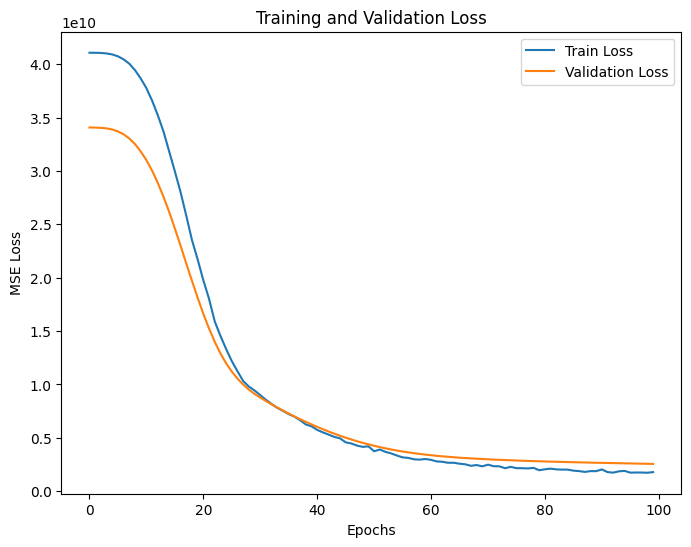

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()